# Домашнее задание 5

Подключаем библиотеки

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

import itertools

import matplotlib.pyplot as plt

%matplotlib inline

Функция построения матрицы ошибок

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Функция вывода матрица

In [3]:
def show_matrix(preds, thresholds, ix):
    font = {'size' : 10}
    plt.rc('font', **font)
    cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
    plt.figure(figsize=(5, 5))
    plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
    #plt.savefig("conf_matrix.png")
    plt.show()

### 1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)

In [4]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Удаляем столбец 'CustomerId' (в лекции)

In [5]:
df.drop(columns=['CustomerId'], inplace=True)
df.head(3)

,RowNumber,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [6]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

- Категориальные признаки закодируем с помощью OneHotEncoding
- Вещественные масштабируем с помощью StandardScaler

In [7]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [8]:
# Зададим списки признаков
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [9]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))

In [10]:
# Объединим все это в единый пайплайн
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

Создадим таблицу с метриками для моделей

In [11]:
models_results = pd.DataFrame()


##### 1) Бустинг (xgboost)

In [12]:
pipeline_1 = Pipeline([
    ('features',feats),
    ('classifier', xgb.XGBClassifier(random_state = 42, use_label_encoder=False, objective='binary:logistic', eval_metric='logloss')),
])

D:\Programming\_venv\ds_gb\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [13]:
#обучим наш пайплайн
pipeline_1.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [14]:
#наши прогнозы для тестовой выборки
preds_1 = pipeline_1.predict_proba(X_test)[:, 1]
preds_1[:10]

array([0.47611395, 0.23087966, 0.0737261 , 0.03141731, 0.02561874,
       0.9679959 , 0.06951059, 0.2885457 , 0.11367497, 0.4902508 ],
      dtype=float32)

In [15]:
precision_1, recall_1, thresholds_1 = precision_recall_curve(y_test, preds_1)

fscore_1 = (2 * precision_1 * recall_1) / (precision_1 + recall_1)
# locate the index of the largest f score
ix_1 = np.argmax(fscore_1)
roc_auc_1 = roc_auc_score(y_test, preds_1)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f, ROC_AUC=%.3f' % (thresholds_1[ix_1], 
                                                                        fscore_1[ix_1],
                                                                        precision_1[ix_1],
                                                                        recall_1[ix_1],
                                                                        roc_auc_1))

Best Threshold=0.373318, F-Score=0.626, Precision=0.619, Recall=0.633, ROC_AUC=0.861


Confusion matrix, without normalization
[[1793  198]
 [ 188  321]]


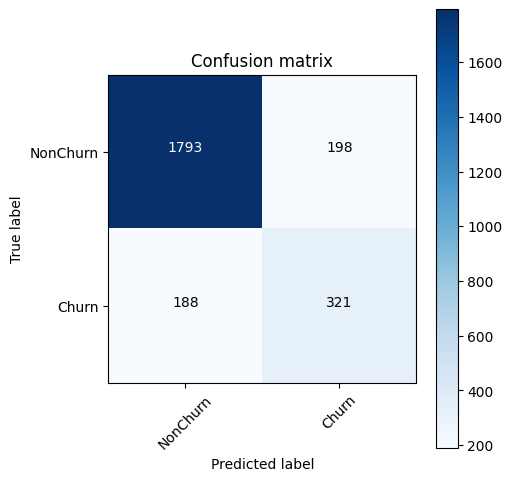

In [16]:
show_matrix(preds_1, thresholds_1, ix_1)

In [17]:
models_results = models_results.append({'model': 'XGBClassifier',
                'thresholds': thresholds_1[ix_1],
                'Precision': precision_1[ix_1],
                'Recall': recall_1[ix_1],
                'F-Score': fscore_1[ix_1],
                'ROC_AUC': roc_auc_1},
                ignore_index=True)
models_results

C:\Users\leva_\AppData\Local\Temp\ipykernel_5272\2258392373.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models_results = models_results.append({'model': 'XGBClassifier',


,model,thresholds,Precision,Recall,F-Score,ROC_AUC
0,XGBClassifier,0.373318,0.619231,0.632613,0.62585,0.860921


##### 2) Логистическая регрессия

In [18]:
pipeline_2 = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])

In [19]:
#обучим наш пайплайн
pipeline_2.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [20]:
#наши прогнозы для тестовой выборки
preds_2 = pipeline_2.predict_proba(X_test)[:, 1]
preds_2[:10]

array([0.22805865, 0.3350657 , 0.15347886, 0.12466446, 0.15507743,
       0.6431308 , 0.06214346, 0.077948  , 0.36717132, 0.76751542])

In [21]:
precision_2, recall_2, thresholds_2 = precision_recall_curve(y_test, preds_2)

fscore_2 = (2 * precision_2 * recall_2) / (precision_2 + recall_2)
# locate the index of the largest f score
ix_2 = np.argmax(fscore_2)
roc_auc_2 = roc_auc_score(y_test, preds_2)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f, ROC_AUC=%.3f' % (thresholds_2[ix_2], 
                                                                        fscore_2[ix_2],
                                                                        precision_2[ix_2],
                                                                        recall_2[ix_2],
                                                                        roc_auc_2))

Best Threshold=0.289522, F-Score=0.510, Precision=0.462, Recall=0.568, ROC_AUC=0.772


Confusion matrix, without normalization
[[1655  336]
 [ 221  288]]


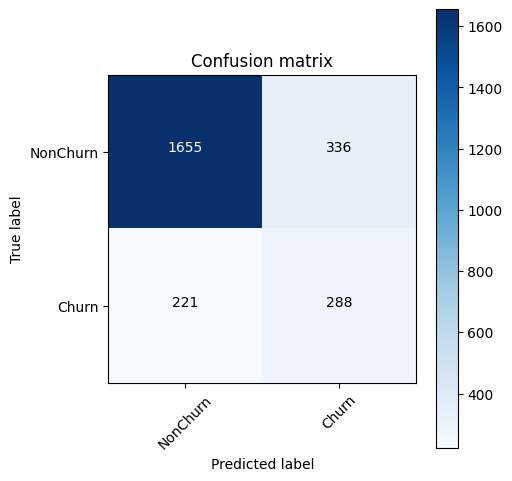

In [22]:
show_matrix(preds_2, thresholds_2, ix_2)

In [23]:
models_results = models_results.append({'model': 'LogisticRegression',
                'thresholds': thresholds_2[ix_2],
                'Precision': precision_2[ix_2],
                'Recall': recall_2[ix_2],
                'F-Score': fscore_2[ix_2],
                'ROC_AUC': roc_auc_2},
                ignore_index=True)
models_results

C:\Users\leva_\AppData\Local\Temp\ipykernel_5272\3715571024.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models_results = models_results.append({'model': 'LogisticRegression',


,model,thresholds,Precision,Recall,F-Score,ROC_AUC
0,XGBClassifier,0.373318,0.619231,0.632613,0.62585,0.860921
1,LogisticRegression,0.289522,0.462400,0.567780,0.50970,0.772077


##### 3) Случайный лес

In [24]:
# модель из лекции
pipeline_3 = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

In [25]:
#обучим наш пайплайн
pipeline_3.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [26]:
#наши прогнозы для тестовой выборки
preds_3 = pipeline_3.predict_proba(X_test)[:, 1]
preds_3[:10]

array([0.37, 0.26, 0.17, 0.02, 0.02, 0.67, 0.04, 0.12, 0.15, 0.75])

In [27]:
precision_3, recall_3, thresholds_3 = precision_recall_curve(y_test, preds_3)

fscore_3 = (2 * precision_3 * recall_3) / (precision_3 + recall_3)
# locate the index of the largest f score
ix_3 = np.argmax(fscore_3)
roc_auc_3 = roc_auc_score(y_test, preds_3)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f, ROC_AUC=%.3f' % (thresholds_3[ix_3], 
                                                                        fscore_3[ix_3],
                                                                        precision_3[ix_3],
                                                                        recall_3[ix_3],
                                                                        roc_auc_3))

Best Threshold=0.380000, F-Score=0.641, Precision=0.654, Recall=0.629, ROC_AUC=0.864


Confusion matrix, without normalization
[[1833  158]
 [ 195  314]]


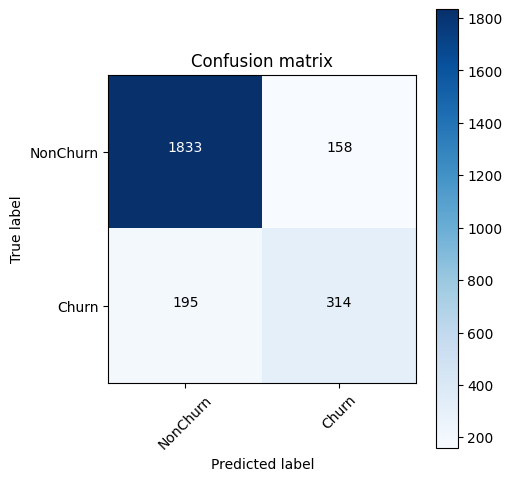

In [28]:
show_matrix(preds_3, thresholds_3, ix_3)

In [29]:
models_results = models_results.append({'model': 'RandomForestClassifier',
                'thresholds': thresholds_3[ix_3],
                'Precision': precision_3[ix_3],
                'Recall': recall_3[ix_3],
                'F-Score': fscore_3[ix_3],
                'ROC_AUC': roc_auc_3},
                ignore_index=True)
models_results

C:\Users\leva_\AppData\Local\Temp\ipykernel_5272\1550064046.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models_results = models_results.append({'model': 'RandomForestClassifier',


,model,thresholds,Precision,Recall,F-Score,ROC_AUC
0,XGBClassifier,0.373318,0.619231,0.632613,0.625850,0.860921
1,LogisticRegression,0.289522,0.462400,0.567780,0.509700,0.772077
2,RandomForestClassifier,0.380000,0.654397,0.628684,0.641283,0.863699


##### 4) Градиентный бустинг

In [30]:
pipeline_4 = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state=42)),
])

In [31]:
#обучим наш пайплайн
pipeline_4.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [32]:
#наши прогнозы для тестовой выборки
preds_4 = pipeline_4.predict_proba(X_test)[:, 1]
preds_4[:10]

array([0.28502357, 0.22926788, 0.1982218 , 0.08930468, 0.04798288,
       0.80662596, 0.03834531, 0.05054472, 0.31038377, 0.73455865])

In [33]:
precision_4, recall_4, thresholds_4 = precision_recall_curve(y_test, preds_4)

fscore_4 = (2 * precision_4 * recall_4) / (precision_4 + recall_4)
# locate the index of the largest f score
ix_4 = np.argmax(fscore_4)
roc_auc_4 = roc_auc_score(y_test, preds_4)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f, ROC_AUC=%.3f' % (thresholds_4[ix_4], 
                                                                        fscore_4[ix_4],
                                                                        precision_4[ix_4],
                                                                        recall_4[ix_4],
                                                                        roc_auc_4))

Best Threshold=0.408508, F-Score=0.646, Precision=0.704, Recall=0.597, ROC_AUC=0.876


Confusion matrix, without normalization
[[1863  128]
 [ 206  303]]


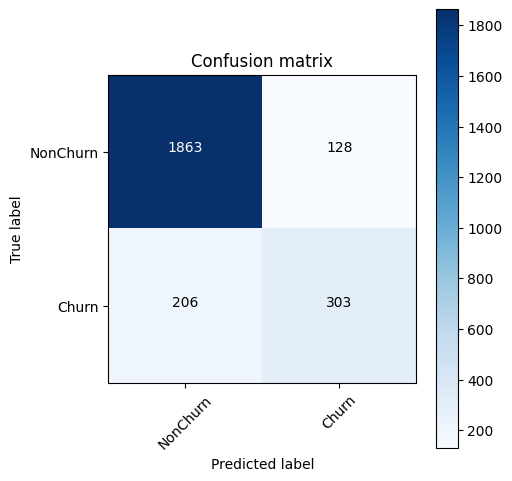

In [34]:
show_matrix(preds_4, thresholds_4, ix_4)

In [35]:
models_results = models_results.append({'model': 'GradientBoostingClassifier',
                'thresholds': thresholds_4[ix_4],
                'Precision': precision_4[ix_4],
                'Recall': recall_4[ix_4],
                'F-Score': fscore_4[ix_4],
                'ROC_AUC': roc_auc_4},
                ignore_index=True)
models_results

C:\Users\leva_\AppData\Local\Temp\ipykernel_5272\456683770.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models_results = models_results.append({'model': 'GradientBoostingClassifier',


,model,thresholds,Precision,Recall,F-Score,ROC_AUC
0,XGBClassifier,0.373318,0.619231,0.632613,0.625850,0.860921
1,LogisticRegression,0.289522,0.462400,0.567780,0.509700,0.772077
2,RandomForestClassifier,0.380000,0.654397,0.628684,0.641283,0.863699
3,GradientBoostingClassifier,0.408508,0.703704,0.597250,0.646121,0.875744


### 2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)

Наверное, f-мера подходит больше всех: нам нужно найти баланс между точностью предсказания(т.е. precision) и охватом(т.е. recall), так как нам неинтересно удерживать тех, кто и так не уйдет, но и упускать большую долю тех, кто точно уйдет тоже не хочется. 

In [36]:
models_results.sort_values(['F-Score'], ascending=False)

,model,thresholds,Precision,Recall,F-Score,ROC_AUC
3,GradientBoostingClassifier,0.408508,0.703704,0.597250,0.646121,0.875744
2,RandomForestClassifier,0.380000,0.654397,0.628684,0.641283,0.863699
0,XGBClassifier,0.373318,0.619231,0.632613,0.625850,0.860921
1,LogisticRegression,0.289522,0.462400,0.567780,0.509700,0.772077


Лучшей моделью по метрикам оказался градиентный бустинг

### 3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.

In [37]:
cnf_matrix = confusion_matrix(y_test, preds_4>thresholds_4[ix_4])
cnf_matrix

array([[1863,  128],
       [ 206,  303]], dtype=int64)

In [38]:
TN = cnf_matrix[0][0]
FP = cnf_matrix[0][1]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]


retain_sum = (FP + TP) * 1
income = TP * 2

income - retain_sum

175

Получилось, что наша модель потенциально экономически целесообразна.

### 4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3

In [39]:
params = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__min_samples_leaf': [1, 2, 3],
    'classifier__max_depth': [3, 4, 5]
}

In [ ]:
%%time
grid = GridSearchCV(pipeline_4,
                    param_grid=params,
                    cv=6,
                    refit=False)

search = grid.fit(X_train, y_train)
search.best_params_

In [ ]:
search.best_params_

In [ ]:
pipeline_5 = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(n_estimators=200, max_depth=3, min_samples_leaf=1, random_state=42)),
])

In [ ]:
#обучим наш пайплайн
pipeline_5.fit(X_train, y_train)

In [ ]:
#наши прогнозы для тестовой выборки
preds_5 = pipeline_5.predict_proba(X_test)[:, 1]
preds_5[:10]

In [ ]:
precision_5, recall_5, thresholds_5 = precision_recall_curve(y_test, preds_5)

fscore_5 = (2 * precision_5 * recall_5) / (precision_5 + recall_5)
# locate the index of the largest f score
ix_5 = np.argmax(fscore_5)
roc_auc_5 = roc_auc_score(y_test, preds_5)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f, ROC_AUC=%.3f' % (thresholds_5[ix_5], 
                                                                        fscore_5[ix_5],
                                                                        precision_5[ix_5],
                                                                        recall_5[ix_5],
                                                                        roc_auc_5))

In [ ]:
models_results = models_results.append({'model': 'best',
                'thresholds': thresholds_5[ix_5],
                'Precision': precision_5[ix_5],
                'Recall': recall_5[ix_5],
                'F-Score': fscore_5[ix_5],
                'ROC_AUC': roc_auc_5},
                ignore_index=True)
models_results

### 5. (опционально) Еще раз провести оценку экономической эффективности

In [ ]:
cnf_matrix_b = confusion_matrix(y_test, preds_5>thresholds_5[ix_5])
cnf_matrix_b

In [ ]:
TN = cnf_matrix_b[0][0]
FP = cnf_matrix_b[0][1]
FN = cnf_matrix_b[1][0]
TP = cnf_matrix_b[1][1]


retain_sum_b = (FP + TP) * 1
income_b = TP * 2

income_b - retain_sum_b

Выгода от улучшенной модели немного уменьшилась.